In [2]:
import os,imageio,time,shutil,logging
import numpy as np
import matplotlib.pyplot as plt
from random import shuffle,sample,choice,choices
from itertools import permutations,combinations

from imgaug.imgaug import imresize_many_images,imresize_single_image
import imgaug.augmenters as iaa
import imgaug as ia

import keras,time
import tensorflow as tf
from tensorflow.keras.models import load_model
import tensorflow.keras.backend as KTF
from tensorflow.keras.layers import Flatten,Dense, Input,Conv2D, Dropout, Lambda, AveragePooling2D,Activation,BatchNormalization
from tensorflow.keras.applications import resnet,vgg16
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.optimizers import RMSprop,Adam,Nadam
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import backend as K
import tensorflow_addons as tfa
import nni

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

2 Physical GPUs, 2 Logical GPUs


In [3]:
 # list all files in a folder with desired extension name (e.g. jpg), the argument target is a list ['.jpg','.png',',bmp']
def findfiles(path,target):
        output = []
        files = os.listdir(path+'/')
        for f in files:
            npath = path + '/' + f
            if(os.path.isfile(npath)):
                if(os.path.splitext(npath)[1] in target):
                    output.append(npath)
            if(os.path.isdir(npath)):
                if (f[0] == '.'):
                    pass
                else:
                    output.extend(findfiles(npath, target))
        return output

# produce image name pairs from given image folders
def pair_list(on_list,off_list):
    # retrieve the length of two types of list
    on_len = len(on_list)
    off_len = len(off_list)
    #assemble them into two pairs list, each item is a triplet (img1_name,img2_name, label), label: 1 for same, 0 for different
    same_on = [(on_list[x[0]],on_list[x[1]],1) for x in  list(permutations(range(on_len),2))]
    same_off = [(off_list[x[0]],off_list[x[1]],1) for x in  list(permutations(range(off_len),2))]
    same = same_on+same_off
    diff = [(x,y,0) for x in on_list for y in off_list]+[(x,y,0) for x in off_list for y in on_list]
    # shuffle created pair lists
    shuffle(same)
    shuffle(diff)
    return same, diff

def partition_img(on,off,part):
    train = [on[:int(part[0]*len(on))],off[:int(part[0]*len(off))]]
    validate = [on[int(part[0]*len(on)):int((part[0]+part[1])*len(on))],off[int(part[0]*len(off)):int((part[0]+part[1])*len(off))]]
    evaluate = [on[-int(part[2]*len(on)):],off[-int(part[2]*len(off)):]]
    return train,validate,evaluate

# partition a dataset into three parts, training and evaluation, e.g. part = [0.7,0.2,0.1]
def partition_pair(same, diff, part):
    train = [same[:int(part[0]*len(same))],diff[:int(part[0]*len(diff))]]
    validate = [same[int(part[0]*len(same)):int((part[0]+part[1])*len(same))],diff[int(part[0]*len(diff)):int((part[0]+part[1])*len(diff))]]
    evaluate = [same[-int(part[2]*len(same)):],diff[-int(part[2]*len(diff)):]]
    return train,validate,evaluate

def produce_pairs(dataset_path,img_format,part):
    onfiles = findfiles(dataset_path+'/on',img_format)
    offfiles = findfiles(dataset_path+'/off',img_format)
    shuffle(onfiles)
    shuffle(offfiles)
    print(dataset_path+' has (on: %d),   (off: %d)'%(len(onfiles),len(offfiles)))
    img_t, img_v, img_e = partition_img(onfiles,offfiles,part)
    print(dataset_path+' is split into  t:%d, v:%d, e:%d '%(length(img_t),length(img_v), length(img_e)))
    t = pair_list(img_t[0],img_t[1])
    v = pair_list(img_v[0],img_v[1])
    e = pair_list(img_e[0],img_e[1])
    print(dataset_path+'  is split into   (training:%d), (evaluation:%d), (testing:%d)'%(len(t[0])+len(t[1]),len(v[0])+len(v[1]),len(e[0])+len(e[1])))
    return t,v,e

def length(input_list):
    return len(input_list[0])+len(input_list[1])

def dataset(constants,partition):
    project_name = constants['project_name']
    dataset_path = constants['dataset_path']
    tmp_path = '/dev/shm/training/'
    if os.path.exists(tmp_path):
        shutil.rmtree(tmp_path, ignore_errors=True)
    shutil.copytree(dataset_path,tmp_path,symlinks=False)
    img_format = ['.jpg','.png','.bmp','.jpeg','.JPG'] 
    t,v,e = produce_pairs(tmp_path,img_format,partition)   
    return t,v,e

In [4]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, dataset, params, constants, aug = False, shuffle = True):
        self.params = params
        self.constants = constants
        self.aug = aug
        self.batch_size = self.params['batch_size']
        self.shuffle = shuffle
        self.dataset = dataset[0] + dataset[1]
        self.augmenters = iaa.Sequential([
            iaa.Affine(rotate=(-params['rotate'], params['rotate'])),
            iaa.Affine(shear=(-params['shear'], params['shear'])),
            iaa.Fliplr(params['Fliplr']), 
            iaa.Dropout(p=(0, params['Dropout'])),
            iaa.Sometimes(
                0.5,
                iaa.GaussianBlur(sigma=(0, params['GaussianBlur']))
            )
        ],random_order=True).to_deterministic(2*self.params['batch_size']) 
        self.on_epoch_end()
        
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.dataset) / self.params['batch_size']))
    
    def __getitem__(self, idx):
        'Generate one batch of data'
        batch_data = self.dataset[idx * self.batch_size: (idx + 1) * self.batch_size]
        inputs, labels = self.__gen__(batch_data, self.constants['input_size'], self.aug)
        return inputs, labels

    def len(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.dataset) / self.params['batch_size']))


    def getitem(self, idx):
        'Generate one batch of data'
        batch_data = self.dataset[idx * self.batch_size: (idx + 1) * self.batch_size]
        inputs, labels = self.__gen__(batch_data, self.constants['input_size'], self.aug)
        return inputs, labels
    
    def __gen__(self, samples, img_size, aug):
        set1 = imresize_many_images([imageio.imread(x[0])[:,:,:3] for x in samples],img_size) #left part
        set2 = imresize_many_images([imageio.imread(x[1])[:,:,:3] for x in samples],img_size) #right part      
        labels = [x[2] for x in samples]
        out1 = []
        out2 = []
        if aug:
            for i in range(len(samples)):
                    augmenter = choice(self.augmenters)
                    out1.append(augmenter.augment_image(set1[i]))
                    out2.append(augmenter.augment_image(set2[i]))
        else:
            out1 = set1
            out2 = set2
        return [np.stack(out1,axis = 0),np.stack(out2,axis = 0)], np.stack(labels,axis = 0)

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        if self.shuffle == True:
            np.random.shuffle(self.dataset)


In [5]:
class Siamese_Model(Model):

    def __init__(self, params):
        super().__init__()
        self.constants = constants
        self.params = params
        self.shape = (constants['input_size'][0], constants['input_size'][1], 3)
        
    def create_base_cnn(self):
        '''Base network to be shared (eq. to feature extraction).
        '''
        # input = Input(shape= self.shape)
        base_cnn = vgg16.VGG16(weights = "imagenet", input_shape = self.shape, include_top= False)
        # x = base_cnn(input)
        x = base_cnn.output
        # x = AveragePooling2D((7, 7), name='avg_pool')(x)
        trainable = False
        for layer in base_cnn.layers:
            if layer.name == "block5_conv1":
                trainable = True
            layer.trainable = trainable
        x = Flatten()(x)
        return Model(inputs = base_cnn.input, outputs = x)

    def create_base_fc(self):
        base = Sequential()
        base.add(Dense(self.params['hidden_size_1']))
        base.add(BatchNormalization())
        base.add(Activation("relu"))

        base.add(Dropout(self.params['dropout_1']))
        base.add(Dense(self.params['hidden_size_2']))
        base.add(BatchNormalization())
        base.add(Activation("relu"))

        # base.add(Dropout(self.params['dropout_2']))
        # base.add(Dense(self.params['hidden_size_3']))
        # base.add(BatchNormalization())
        # base.add(Activation("relu"))
        base.add(Dense(1024, activation='sigmoid'))
        return base
        
    def contrastive_loss(self,y_true, y_pred):
        y_true = tf.cast(y_true,tf.float32)
        margin = 1
        return K.mean(y_true * K.square(y_pred) +
                    (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

    def accuracy(self, y_true, y_pred):
        return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

    def euclidean_distance(self, vects):
        x, y = vects
        return K.sqrt(K.maximum(K.sum(K.square(x - y), axis=1, keepdims=True), K.epsilon()))

    def eucl_dist_output_shape(self, shapes):
        shape1, shape2 = shapes
        return (shape1[0], 1)

    def assemble(self):
        strategy = tf.distribute.MirroredStrategy()
        with strategy.scope():
            base_cnn = self.create_base_cnn()
            base_fc = self.create_base_fc()
            input_a = Input(shape=self.shape)
            input_b = Input(shape=self.shape)
            feature_a = base_cnn(input_a)
            feature_b = base_cnn(input_b)
            processed_a = base_fc(feature_a)
            processed_b = base_fc(feature_b)

            distance = Lambda(self.euclidean_distance,
                            output_shape=self.eucl_dist_output_shape)([processed_a, processed_b])          
            model = Model([input_a, input_b], distance)
    
        nadam = Nadam(learning_rate=self.params['lr'])
        # adam = Adam(learning_rate=self.params['lr'])
        # model.compile(loss=contrastive_loss, optimizer=adam, metrics=[accuracy])
        model.compile(loss=tfa.losses.contrastive_loss, optimizer=nadam, metrics=[self.accuracy])

        return model

In [6]:
constants = {
    "input_size":(224,224),
    "project_name": "heater_g",
    "dataset_path": "./dataset/heater_g/",
    "augmented": True
}
params = {
    "batch_size": 16,
    "rotate": 15,
    "shear": 15,
    "Fliplr": 0.3,
    "Dropout": 0.15,
    "GaussianBlur": 1, 
    "conv_layers": 3, 
    'dropout_1': 0.4,
    'dropout_2': 0.2,
    "hidden_size_1": 512,
    "hidden_size_2": 512,
    "hidden_size_3": 256,
    "lr": 0.01
}

t,v,e = dataset(constants, [0.7,0.15,0.15])

training_generator = DataGenerator(t, params, constants, constants['augmented'])
validation_generator = DataGenerator(v, params, constants)

siamese = Siamese_Model(params)
model = siamese.assemble()


/dev/shm/training/ has (on: 107),   (off: 39)
/dev/shm/training/ is split into  t:101, v:22, e:21 
/dev/shm/training/  is split into   (training:10100), (evaluation:462), (testing:420)
[2021-06-23 22:59:51] WARNING (tensorflow/MainThread) Collective ops is not configured at program startup. Some performance features may not be enabled.
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
[2021-06-23 22:59:52] INFO (tensorflow/MainThread) Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
[2021-06-23 22:59:52] INFO (tensorflow/MainThread) Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflo

In [14]:

# model.summary()
time_stamp = time.strftime("%b-%d-%H_%M", time.localtime())
callbacks_list = [
          # This callback will interrupt training when we have stopped improving
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            min_delta = 0.001,
            restore_best_weights = True,
            patience=5,
        )
        ,tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss', factor=0.2, patience=3, verbose=1,
            mode='auto', min_delta=0.0001, cooldown=0, min_lr=0.00001,
        )
        ,tf.keras.callbacks.ModelCheckpoint(
            filepath= './model/'+constants['project_name']+'%'+time_stamp+'.h5', # Path to the destination model file
            # The two arguments below mean that we will not overwrite the
            # model file unless `val_loss` has improved, which
            # allows us to keep the best model every seen during training.
            monitor='val_loss',
            verbose = 1,
            save_best_only=True,
        )
        ,tf.keras.callbacks.TensorBoard(
            log_dir= './logs/'+constants['project_name']+'/',  # log 目录
            histogram_freq=0,  # 按照何等频率（epoch）来计算直方图，0为不计算
            write_graph=True,  # 是否存储网络结构图
            write_images=True,# 是否可视化参数
            embeddings_freq=0, 
            embeddings_layer_names=None, 
            embeddings_metadata=None
        )
]
history = model.fit(
  training_generator,
  # steps_per_epoch = 1000,
  epochs=100,
  verbose=1, 
  validation_data = validation_generator,
  # validation_steps = 300,
  callbacks = callbacks_list,
  use_multiprocessing = True,
  workers=10,
  shuffle = True
)

with open('./history/'+constants['project_name']+'%'+time_stamp+'_dict', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)


Epoch 1/100
INFO:tensorflow:batch_all_reduce: 16 all-reduces with algorithm = nccl, num_packs = 1
[2021-06-23 21:06:49] INFO (tensorflow/MainThread) batch_all_reduce: 16 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 16 all-reduces with algorithm = nccl, num_packs = 1
[2021-06-23 21:06:51] INFO (tensorflow/MainThread) batch_all_reduce: 16 all-reduces with algorithm = nccl, num_packs = 1
435/435 [==============================] - 44s 84ms/step - loss: 0.0146 - accuracy: 0.9848 - val_loss: 1.1557e-05 - val_accuracy: 1.0000

Epoch 00001: val_loss improved from inf to 0.00001, saving model to ./model/door_zhao%Jun-23-21_06.h5
Epoch 2/100
435/435 [==============================] - 36s 81ms/step - loss: 0.0068 - accuracy: 0.9928 - val_loss: 6.2921e-07 - val_accuracy: 1.0000

Epoch 00002: val_loss improved from 0.00001 to 0.00000, saving model to ./model/door_zhao%Jun-23-21_06.h5
Epoch 3/100
435/435 [==============================] - 36s 81ms/step - loss: 0

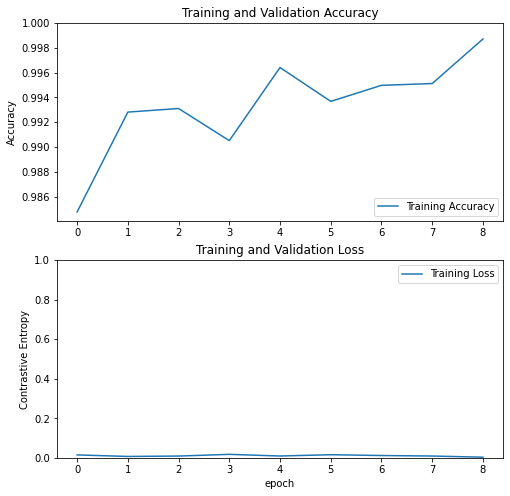

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
# plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
# plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Contrastive Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [12]:
evaluation_generator = DataGenerator(e, params, constants)
scores = model.evaluate(evaluation_generator, verbose=1)
print('evaluate loss is %f,  accuracy is %f'%(scores[0],scores[1]))

19/19 [==============================] - 11s 203ms/step - loss: 0.0564 - accuracy: 1.0000
evaluate loss is 0.056371,  accuracy is 1.000000


In [11]:
model_path = './model/door_g%Jun-23-20_25.h5'
model.load_weights(model_path)

In [ ]:
eval_sample = training_generator.dataset[0]
left = eval_sample[0] 
right = eval_sample[1] 
label = eval_sample [2]

left = imresize_single_image(imageio.imread(left),(224,224))
right = imresize_single_image(imageio.imread(right),(224,224))
output_label = model.predict((np.expand_dims(left,axis = 0),np.expand_dims(right,axis = 0)))
float(output_label)

In [2]:
counter = 0
for eval_sample in training_generator.dataset:
    left = imresize_single_image(imageio.imread(eval_sample[0]),(224,224))
    right = imresize_single_image(imageio.imread(eval_sample[1]),(224,224))
    label = eval_sample[2]
    # ia.imshow(np.hstack([left[:,:,:],right[:,:,:]]))
    output_label = model.predict((np.expand_dims(left,axis = 0),np.expand_dims(right,axis = 0)))
    predicted = round(float(output_label))
    if predicted != label:
        ia.imshow(np.hstack([left[:,:,:],right[:,:,:]]))
        print("ground truth is %d" %label)
        print("predicted is %d" %predicted)
        print(eval_sample)    
        print("==========================================================================================")

NameError: name 'training_generator' is not defined

In [ ]:
from random import sample
images, labels = evaluation_generator.getitem(1)

left = images[0]
right = images[1]

for i in sample(range(len(labels)),5):
    print("==============================")
    ia.imshow(np.hstack([left[i,:,:,:],right[i,:,:,:]]))
    print('ground_truth:  ')
    if labels[i] == 1:
        print('same pair')
    else:
        print('different pair')

    test_input = (np.expand_dims(left[i],axis = 0),np.expand_dims(right[i],axis = 0))
    predicted = model.predict(test_input)
    print("predicted is : %f"%predicted)
    if predicted < 0.5:
        print('same')
    else:
        print('different')
    print("==============================")
    # test_input = (np.expand_dims(img1[i],axis = 0),np.expand_dims(img2[i],axis = 0))
    # print('\npredicted:   ')
    # output = model.predict(test_input)
    # print(output)
        